In [29]:
import os
import cv2
import torch
from torchvision import transforms
from prototypical_net import ConvNet
from PIL import Image
import random
from detect_object_multiscale import detect_object_multiscale
from matplotlib import pyplot as plt

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_sizes=[84, 96, 112, 128]
stride=20
extensions=(".jpg", ".jpeg", ".png")
# Load model
model = ConvNet().to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()


ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

### Transforms

In [31]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [32]:
workspace_path = "images/workspace-images/workspace15.png"
target_class = "apple"

support_dir = os.path.join("images/support-images", target_class)
support_paths = [
    os.path.join(support_dir, f)
    for f in os.listdir(support_dir)
    if f.lower().endswith(extensions)
]

# Select up to 10 random support images (or fewer if not enough)
selected_paths = random.sample(support_paths, k=min(10, len(support_paths)))

# Load, transform, and embed all support images
embeddings = []
for path in selected_paths:
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(tensor)
        embeddings.append(emb)

# Compute average embedding = class prototype
support_embedding = torch.mean(torch.stack(embeddings), dim=0)

# Load and process workspace image
workspace = cv2.imread(workspace_path)
workspace = cv2.cvtColor(workspace, cv2.COLOR_BGR2RGB)

In [33]:
result = detect_object_multiscale(
    model=model,
    support_path_list=support_paths,
    workspace_path=workspace_path,
    patch_sizes=patch_sizes,
    stride=stride,
    device=device,
    distance=6,
    threshold=0.0,
    confidence=0.0
)
result
# Print the results
# print(f"Best match at: {result['location']}, Distance: {result['distance']:.4f}, Patch Size: {result['patch_size']}, Confidence: {result['confidence']:.4f}")


[{'location': (296, 476),
  'distance': 2.964061737060547,
  'patch_size': 112,
  'confidence': 0.2522665049968484},
 {'location': (76, 396),
  'distance': 3.554734230041504,
  'patch_size': 112,
  'confidence': 0.2195517783242619},
 {'location': (476, 376),
  'distance': 3.716632604598999,
  'patch_size': 112,
  'confidence': 0.21201566537638317},
 {'location': (156, 196),
  'distance': 3.8557345867156982,
  'patch_size': 112,
  'confidence': 0.20594206337714513},
 {'location': (644, 484),
  'distance': 3.933582305908203,
  'patch_size': 128,
  'confidence': 0.20269247333777157},
 {'location': (376, 176),
  'distance': 4.038407802581787,
  'patch_size': 112,
  'confidence': 0.1984753992099605},
 {'location': (704, 304),
  'distance': 4.305140018463135,
  'patch_size': 128,
  'confidence': 0.18849643864624965},
 {'location': (664, 104),
  'distance': 4.4688639640808105,
  'patch_size': 128,
  'confidence': 0.18285333234981588}]

In [34]:
print(f"Number of detected objects: {len(result)}")

Number of detected objects: 8


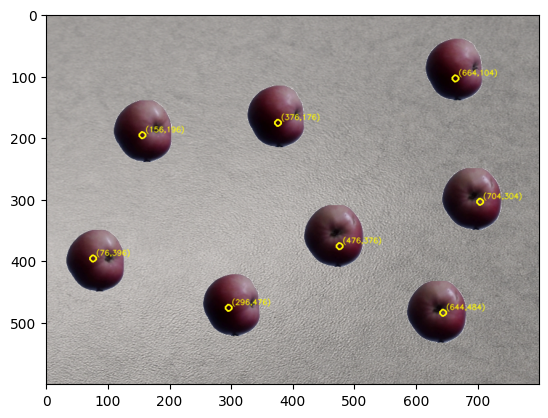

In [35]:
detected = "images/detected.png"
os.remove(detected) if os.path.exists(detected) else None
if result == []:
    print("Object not detected on the workspace.")
else:
    for loc in result:
        x, y = loc['location']
        cv2.circle(workspace, (x, y), 5, (255, 250, 0), 2)
        # Write coordinates near the circle
        text = f"({x},{y})"
        cv2.putText(workspace, text, (x + 5, y - 5), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=0.4, color=(255, 250, 0), thickness=1, lineType=cv2.LINE_AA)
    cv2.imwrite(detected, cv2.cvtColor(workspace, cv2.COLOR_RGB2BGR))
    plt.imshow(workspace)